# Causal Inference of Netflix Stock Drop with Time Series Forecasting

## Author:
- Yash Pankhania (pankhania.y@northeastern.edu)

Github Repository URL: https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference

## Abstract

This notebook provides a causal analysis of the impact of a dramatic drop in Netflix's (NFLX) stock price on April 20, 2022, using time series forecasting and synthetic control methods. By constructing a counterfactual from correlated stocks and employing FB Prophet and Google's CausalImpact for post-event evaluation, the study seeks to quantify the effect of Netflix's declining subscriber growth on its stock performance. The analysis navigates through data preprocessing challenges and employs robust statistical techniques to offer a granular understanding of the event's influence, delivering valuable insights for investors and analysts on the stock's behavior in response to company-specific developments.

## Introduction
The goal of this analysis is to estimate the impact that Netflix's significant stock drop on April 20, 2022, had on their stock price. To estimate the impact, I will build a counterfactual using other stocks that correlate with the Netflix stock in the time before the stock drop (pre period). The counterfactual is a synthetic control and will be compared to the empirical Netflix data in the time after the stock drop (post period). The notebook includes data preprocessing, exploratory data analysis, and time series forecasting, with a summary of findings at the end.

More context around Netflix's stock drop on April 20, 2022: On this date, Netflix experienced one of its most significant stock drops. This drop was largely attributed to a decrease in subscriber growth, which was a significant concern for investors. The decline in subscriber numbers was a notable shift from the rapid growth Netflix had experienced in previous years. This sudden change in the company's fortunes led to a considerable loss in market confidence, reflected in the substantial decline in stock price.

### Understanding Causal Inference

Causal inference is the process of drawing conclusions about causal relationships from data. It's a way to understand whether and how an action or intervention will produce a particular effect.

![image](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/6d6bbefd-fd38-438b-b2ab-ab8b6b4d363e)

### Key Principles:

- **Cause-and-Effect**: At the heart of causal inference is the distinction between causation and correlation. Causal inference seeks to establish that one event leads to the occurrence of another and is not merely associated with it.
  
- **Counterfactual Reasoning**: This involves considering what would have happened if the cause had not occurred, which is essential for establishing a causal link.

- **Randomized Experiments**: Often considered the gold standard for causal inference, randomized controlled trials randomly assign subjects to treatment or control groups to isolate the effect of the treatment.

### Methods and Techniques:

- **Observational Studies**: When randomized experiments are not possible, observational data is used, but these studies must carefully control for confounders—variables that could affect both the cause and the effect.
  
- **Statistical Models**: Regression analysis, structural equation modeling, and other statistical techniques are employed to estimate causal effects, often adjusting for potential confounders.

- **Econometric Methods**: Instrumental variables, difference-in-differences, and regression discontinuity designs are among the econometric methods used to infer causality.

### Challenges:

- **Confounding Variables**: Identifying and adjusting for all potential confounders is a major challenge in observational studies.
  
- **External Validity**: Even when a causal relationship is established, it may not hold in different settings or populations.

### Applications:

- **Policy Evaluation**: Assessing the impact of policy interventions on social and economic outcomes.
  
- **Medicine**: Determining the effectiveness of treatments and interventions.

- **Business**: Evaluating the impact of strategic decisions, marketing campaigns, and other business actions.

In [1]:
# Installs packages necessary for stock data analysis and modeling
!pip install yfinance pycausalimpact cmdstanpy pystan prophet

In [2]:
# Imports necessary Python libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet
from causalimpact import CausalImpact
import os
from prophet.plot import plot_plotly, plot_components_plotly
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Sets the pre- and post-event periods for the Netflix stock analysis
pre_period = [pd.to_datetime('2019-1-1'), pd.to_datetime('2022-4-19')]
post_period = [pd.to_datetime('2022-4-20'), pd.to_datetime('2022-5-31')]

In [4]:
# Loads Netflix stock price data
stock_data = pd.read_csv('https://raw.githubusercontent.com/Draconian10/Stocks_Time_Series_Causal_Inference/main/NFLX_Stock_Prices.csv')

In [5]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,02-01-2019,38.722500,39.712502,38.557499,39.480000,37.893330,148158800,AAPL
1,03-01-2019,35.994999,36.430000,35.500000,35.547501,34.118885,365248800,AAPL
2,04-01-2019,36.132500,37.137501,35.950001,37.064999,35.575378,234428400,AAPL
3,07-01-2019,37.174999,37.207500,36.474998,36.982498,35.496208,219111200,AAPL
4,08-01-2019,37.389999,37.955002,37.130001,37.687500,36.172871,164101200,AAPL


In [6]:
# Pivots the DataFrame to reorganize the stock data, setting dates as index and tickers as columns
stock_data = stock_data.pivot(index='Date', columns='Ticker', values='Adj Close')

In [7]:
stock_data.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01-02-2019,39.956924,64.516396,66.846581,144.270050,247.380005,91.434135,127.563187,37.128326,24.510000,160.552780,153.060242,81.311501,227.094223,96.349724,376.464477,25.127848,1836.959961,365.536133,42.806068,209.190002,53.435738,116.642998,121.790489,32.960068,57.372944,196.859650,155.869995,40.993710,56.901863,94.998512,153.044769,94.824715,109.599014,285.561371,68.073174,60.044426,57.764496,55.537498,55.931000,174.515808,163.005478,130.617096,100.452576,42.499737,207.702637,174.883331,117.212837,89.986443,41.661552,153.117233,111.527336,254.309601,89.157761,161.059738,208.280075,157.417541,41.028008,78.264931,165.710007,83.767891,63.049908,36.090176,97.599594,39.714970,339.850006,77.454048,221.509995,35.901451,46.998882,73.423332,97.390282,33.896126,86.561600,58.885475,61.623306,58.051022,43.666645,430.149994,66.172546,61.649097,43.735142,94.790001,185.373795,168.120544,15.505880,45.671394,240.707611,69.327362,20.813999,89.461899,249.372040,143.093887,90.398865,135.451111,191.520004,42.808590,42.634441,86.373985,58.786533,84.397530
01-02-2021,131.812073,91.365059,116.824242,238.294403,470.000000,143.873840,156.639526,98.657906,87.660004,218.501190,219.404495,167.143997,431.358032,112.930458,195.839996,27.857887,1990.459961,660.955200,56.920933,229.320007,52.545113,174.159744,141.237930,46.835735,36.164055,342.956543,228.460007,41.828983,66.464348,76.255531,282.712341,211.862488,170.414597,282.406220,114.527809,66.416351,58.011482,95.067497,94.653503,254.969360,251.064957,184.308121,99.588264,51.935562,367.201416,248.703339,150.092514,119.884979,44.251709,239.755371,195.481033,298.373016,155.429337,485.359405,316.597961,194.421249,51.926636,102.980919,262.010010,105.761192,67.619354,61.781265,233.382263,76.295433,539.039978,131.564774,558.559998,132.072327,58.876865,120.453331,126.006149,32.267269,120.441086,84.123909,99.081306,68.419228,151.254822,508.079987,62.243660,92.779060,51.360798,263.570007,313.443176,219.730225,17.557426,61.064007,512.279480,127.861839,279.936676,159.840897,320.380768,185.833695,142.405350,194.127243,231.770004,46.353947,28.030720,132.940597,39.359322,152.447922
01-02-2022,172.637497,128.057602,123.079826,344.100311,535.979981,159.264191,197.237412,136.075317,116.779999,214.252213,237.584930,151.193497,564.054199,178.997345,208.339996,44.486752,2465.639893,780.570862,61.585403,313.959992,61.162716,197.562882,194.113922,47.496838,84.069069,501.235352,232.119995,52.395191,101.211617,125.184822,369.655457,252.648621,144.020630,428.811035,153.173233,75.954453,63.620945,137.878494,137.643997,343.805420,349.914642,196.832382,123.016411,46.007507,554.036926,286.510010,161.601502,143.136826,57.020832,312.211243,242.540085,367.152802,229.963730,575.753723,387.920898,247.708527,64.031937,98.015938,319.000000,149.737228,77.767357,97.344833,303.205261,73.540543,457.130005,144.773117,586.539978,246.040665,78.757332,170.953339,163.165161,49.543591,152.832214,107.509033,146.508514,94.047607,168.867325,613.359985,86.385544,94.484970,87.582954,311.820007,409.747467,243.538544,16.520103,70.416534,591.816284,109.073860,310.416656,172.072830,455.627472,235.279831,214.759827,228.798630,245.660004,47.553902,52.675770,136.645050,75.179047,195.951126
01-03-2019,42.164593,64.195824,72.601921,153.089935,264.010010,99.123924,138.624344,36.606247,23.680000,165.331573,159.786896,83.586502,232.150024,101.809494,430.299957,26.083775,1714.079956,389.179565,45.663239,203.130005,54.107143,122.488068,122.2920

In [8]:
# Outputs the shape of the DataFrame to understand the size of the dataset
stock_data.shape

(1008, 100)

In [9]:
# Generates descriptive statistics of the dataset for a preliminary analysis
stock_data.describe()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,109.030964,96.386434,97.706204,241.580886,413.027004,130.282316,174.540650,85.176258,71.873512,206.555324,219.966402,129.206477,380.846381,129.680646,236.622521,31.004248,1990.868809,590.029454,56.472000,247.471915,53.869792,162.073121,155.297328,41.985138,59.658587,369.568397,195.024494,44.780698,71.424258,104.575403,259.927062,189.264795,136.160484,342.725776,112.425270,63.111103,60.001424,93.512765,93.083453,258.065629,254.654540,174.492758,111.019127,45.948465,366.494984,234.024345,142.922393,116.004247,49.435143,241.661383,192.702097,350.708019,154.108359,393.123561,311.135376,207.769123,54.048367,96.731942,229.439504,122.227460,73.812447,62.011772,211.691679,65.396440,404.800039,111.626394,426.907847,130.515236,63.772125,115.831508,135.248726,36.964791,122.436007,88.734459,100.632333,75.563248,107.586656,524.047272,76.275290,85.741289,55.279989,228.171399,320.120347,215.103169,17.683968,58.598163,434.217731,110.246504,159.332963,139.626738,351.989738,185.961632,141.904406,193.409004,228.808254,46.108192,39.052903,123.700086,58.828480,150.688413
std,43.227053,30.070920,18.067980,63.515088,117.496059,27.653849,37.122231,37.072607,32.943358,28.026531,29.832097,33.396156,122.243850,29.258632,82.575084,6.995638,281.961168,162.905301,10.077989,46.271751,9.378814,41.541899,31.443499,6.946496,24.817714,107.283867,43.823874,5.747434,17.571436,29.776778,100.391275,57.810104,28.499872,91.683104,33.212990,13.576032,6.400058,30.509864,30.072634,77.094037,57.988835,28.437018,11.765933,8.054186,114.267926,57.354169,18.765678,23.000717,6.679870,56.457560,78.810115,48.863757,47.293078,159.677396,46.926299,30.860325,6.538917,13.381339,69.460435,28.941804,9.437956,22.102456,65.410580,13.512454,125.498968,27.422628,133.707366,74.563507,14.368368,44.304749,21.415368,7.506011,18.420790,19.861779,26.572654,12.843049,35.283231,132.626396,12.541160,15.094261,17.745508,83.741300,74.910005,31.461750,1.634890,8.375391,123.109218,25.943713,116.340118,31.513082,106.072400,32.201625,41.125607,25.012472,41.955921,3.888886,8.605894,16.971684,19.614483,35.284234
min,34.118885,51.924202,58.973114,126.602226,215.699997,73.418312,100.884674,29.789551,17.049999,144.954880,140.765533,75.014000,148.367325,65.374565,95.010002,16.476816,1152.239990,298.122925,37.348862,162.130005,30.533733,84.208206,88.294693,27.861526,19.498018,187.637848,124.300003,29.55

In [10]:
# Counts the number of missing values in each column of the dataset
stock_data.isna().sum()

Ticker
AAPL    0
ABBV    0
ABT     0
ACN     0
ADBE    0
       ..
VZ      0
WFC     0
WMT     0
XOM     0
ZTS     0
Length: 100, dtype: int64

In [11]:
# Copy the DataFrame
adj_close = stock_data.copy()

# Adjusts the DataFrame to set the date as the index for time series analysis
adj_close.index = pd.to_datetime(adj_close.index)

adj_close.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,39.956924,64.516396,66.846581,144.270050,247.380005,91.434135,127.563187,37.128326,24.510000,160.552780,153.060242,81.311501,227.094223,96.349724,376.464477,25.127848,1836.959961,365.536133,42.806068,209.190002,53.435738,116.642998,121.790489,32.960068,57.372944,196.859650,155.869995,40.993710,56.901863,94.998512,153.044769,94.824715,109.599014,285.561371,68.073174,60.044426,57.764496,55.537498,55.931000,174.515808,163.005478,130.617096,100.452576,42.499737,207.702637,174.883331,117.212837,89.986443,41.661552,153.117233,111.527336,254.309601,89.157761,161.059738,208.280075,157.417541,41.028008,78.264931,165.710007,83.767891,63.049908,36.090176,97.599594,39.714970,339.850006,77.454048,221.509995,35.901451,46.998882,73.423332,97.390282,33.896126,86.561600,58.885475,61.623306,58.051022,43.666645,430.149994,66.172546,61.649097,43.735142,94.790001,185.373795,168.120544,15.505880,45.671394,240.707611,69.327362,20.813999,89.461899,249.372040,143.093887,90.398865,135.451111,191.520004,42.808590,42.634441,86.373985,58.786533,84.397530
2021-01-02,131.812073,91.365059,116.824242,238.294403,470.000000,143.873840,156.639526,98.657906,87.660004,218.501190,219.404495,167.143997,431.358032,112.930458,195.839996,27.857887,1990.459961,660.955200,56.920933,229.320007,52.545113,174.159744,141.237930,46.835735,36.164055,342.956543,228.460007,41.828983,66.464348,76.255531,282.712341,211.862488,170.414597,282.406220,114.527809,66.416351,58.011482,95.067497,94.653503,254.969360,251.064957,184.308121,99.588264,51.935562,367.201416,248.703339,150.092514,119.884979,44.251709,239.755371,195.481033,298.373016,155.429337,485.359405,316.597961,194.421249,51.926636,102.980919,262.010010,105.761192,67.619354,61.781265,233.382263,76.295433,539.039978,131.564774,558.559998,132.072327,58.876865,120.453331,126.006149,32.267269,120.441086,84.123909,99.081306,68.419228,151.254822,508.079987,62.243660,92.779060,51.360798,263.570007,313.443176,219.730225,17.557426,61.064007,512.279480,127.861839,279.936676,159.840897,320.380768,185.833695,142.405350,194.127243,231.770004,46.353947,28.030720,132.940597,39.359322,152.447922
2022-01-02,172.637497,128.057602,123.079826,344.100311,535.979981,159.264191,197.237412,136.075317,116.779999,214.252213,237.584930,151.193497,564.054199,178.997345,208.339996,44.486752,2465.639893,780.570862,61.585403,313.959992,61.162716,197.562882,194.113922,47.496838,84.069069,501.235352,232.119995,52.395191,101.211617,125.184822,369.655457,252.648621,144.020630,428.811035,153.173233,75.954453,63.620945,137.878494,137.643997,343.805420,349.914642,196.832382,123.016411,46.007507,554.036926,286.510010,161.601502,143.136826,57.020832,312.211243,242.540085,367.152802,229.963730,575.753723,387.920898,247.708527,64.031937,98.015938,319.000000,149.737228,77.767357,97.344833,303.205261,73.540543,457.130005,144.773117,586.539978,246.040665,78.757332,170.953339,163.165161,49.543591,152.832214,107.509033,146.508514,94.047607,168.867325,613.359985,86.385544,94.484970,87.582954,311.820007,409.747467,243.538544,16.520103,70.416534,591.816284,109.073860,310.416656,172.072830,455.627472,235.279831,214.759827,228.798630,245.660004,47.553902,52.675770,136.645050,75.179047,195.951126
2019-01-03,42.164593,64.195824,72.601921,153.089935,264.010010,99.123924,138.624344,36.606247,23.680000,165.331573,159.786896,83.586502,232.150024,101.809494,430.299957,26.083775,1714.079956,389.179565,45.663239,203.130005,54.107143,122.488068,122.2920

## Data Preprocessing

### Fixing missing dates
The dataset obtained from Yahoo Finance excludes dates when the stock market was not trading. These omitted dates can create problems for the time series forecasting models that will be utilized later in the notebook.

In [12]:
# Create a dataframe with the complete date range
full_dates = pd.date_range(start = pre_period[0], end = post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['full_dates'])

# Left join the stock data to the dataframe with the full date range
adj_close = full_dates.merge(adj_close, left_on='full_dates', right_index=True, how='left')

# Put the date in the index
adj_close.set_index('full_dates', inplace=True)

In [13]:
adj_close.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
full_dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,39.956924,64.516396,66.846581,144.270050,247.380005,91.434135,127.563187,37.128326,24.510000,160.552780,153.060242,81.311501,227.094223,96.349724,376.464477,25.127848,1836.959961,365.536133,42.806068,209.190002,53.435738,116.642998,121.790489,32.960068,57.372944,196.859650,155.869995,40.993710,56.901863,94.998512,153.044769,94.824715,109.599014,285.561371,68.073174,60.044426,57.764496,55.537498,55.931000,174.515808,163.005478,130.617096,100.452576,42.499737,207.702637,174.883331,117.212837,89.986443,41.661552,153.117233,111.527336,254.309601,89.157761,161.059738,208.280075,157.417541,41.028008,78.264931,165.710007,83.767891,63.049908,36.090176,97.599594,39.714970,339.850006,77.454048,221.509995,35.901451,46.998882,73.423332,97.390282,33.896126,86.561600,58.885475,61.623306,58.051022,43.666645,430.149994,66.172546,61.649097,43.735142,94.790001,185.373795,168.120544,15.505880,45.671394,240.707611,69.327362,20.813999,89.461899,249.372040,143.093887,90.398865,135.451111,191.520004,42.808590,42.634441,86.373985,58.786533,84.397530
2019-01-03,42.164593,64.195824,72.601921,153.089935,264.010010,99.123924,138.624344,36.606247,23.680000,165.331573,159.786896,83.586502,232.150024,101.809494,430.299957,26.083775,1714.079956,389.179565,45.663239,203.130005,54.107143,122.488068,122.292000,35.029606,57.843231,205.999695,164.529999,44.518097,50.716114,98.920364,152.512497,110.848602,112.267601,289.694855,71.410957,62.936462,54.433037,57.049500,57.425999,176.700470,163.712784,141.304413,105.487824,46.780117,242.531250,186.183334,121.638977,90.462891,38.821388,155.537430,119.505852,272.792908,95.446823,164.769943,221.413849,165.887146,42.522552,81.614967,162.279999,86.218285,67.338455,36.677006,107.314537,42.170380,357.320007,83.036003,243.520004,38.848690,48.571365,81.823334,101.671753,34.275570,87.423035,65.346748,62.040577,67.081009,47.706749,439.570007,70.364555,64.463882,43.692440,103.190002,193.580841,181.650970,15.929708,48.776581,261.106903,72.025581,19.652666,93.645966,228.427032,150.837341,96.383942,144.710815,192.160004,44.699856,43.610744,90.119362,62.633495,92.736526
2019-01-04,46.085365,64.740807,73.590385,164.389893,272.170013,98.977676,146.743408,39.046028,26.360001,165.859192,172.889908,90.709503,262.596893,104.427193,382.369537,25.398533,1759.229980,387.384613,40.403648,205.000000,54.014824,124.965111,129.687393,36.113644,56.802673,229.233841,161.179993,47.609512,47.278618,101.279282,151.934631,114.531509,110.790520,272.188751,73.847740,61.960232,54.851402,59.721500,59.949001,175.398865,174.257507,146.522125,108.594864,47.842091,257.388641,191.846664,122.192886,90.644798,40.316635,163.960266,119.700638,268.226807,100.009842,173.238632,232.910828,168.881287,44.972961,80.814758,168.699997,88.000374,69.165443,37.565891,113.503723,42.829147,366.959992,81.197304,245.729996,45.262634,50.486099,80.470001,106.764992,33.864498,92.041077,65.114082,64.582077,68.466026,51.475945,410.049988,74.515831,67.293564,41.190929,117.570000,204.188324,186.430817,16.513762,49.892384,273.301880,69.665886,19.278667,

### Filling missing data
Populate the dataset with values from preceding dates for the missing dates using a backfill method. Create visual representations of the dataset both before and after this imputation process.

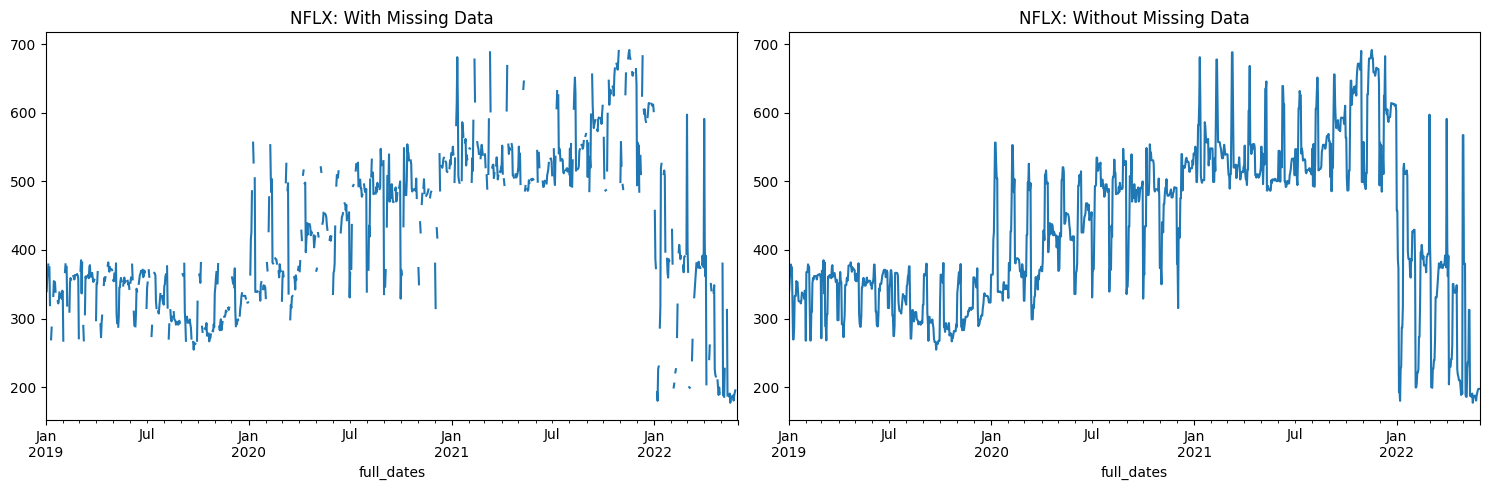

In [14]:
# Create a side-by-side comparison of NFLX stock prices with and without missing data
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
adj_close['NFLX'].plot()
plt.title('NFLX: With Missing Data')
plt.subplot(1, 2, 2)
adj_close = adj_close.fillna(method='bfill')
adj_close['NFLX'].plot()
plt.title('NFLX: Without Missing Data')
plt.tight_layout()
plt.show()

### Netflix (NFLX) Stock Price Analysis: The Effect of Data Completeness

This analysis presents two line charts detailing the Netflix (NFLX) adjusted closing stock prices. Each chart provides a perspective on the importance of data integrity in time series forecasting.

#### 1. **NFLX: With Missing Data**
   - **Overview**: The chart illustrates fluctuations in Netflix's adjusted closing stock prices, with an emphasis on data gaps.
   - **Key Points**:
     - **Gaps in Data**: Indicated by the intermittent discontinuities along the price line.
     - **Analytical Implications**: The absent data complicates the assessment of stock behavior over the affected intervals.

#### 2. **NFLX: Without Missing Data**
   - **Overview**: This chart replicates the price trajectory from the first, but with interventions to address data gaps.
   - **Data Management**: The gaps were bridged using backward filling (`fillna(method='bfill')`), a common technique in time series analysis.
   - **Key Points**:
     - **Seamless Data Flow**: Achieves a consistent and uninterrupted line representation.
     - **Clarity in Trends**: Offers an unobstructed historical performance, thus enhancing the reliability of the trend analysis.

### Flag before and after Gen AI Boom announcement
We create a column to identify the data before and after the Gen AI Boom announcement.

In [15]:
# Flags data points as belonging to either pre or post the specified event date
adj_close['gen_ai_boom_timeframe'] = adj_close.index.map(lambda x: 'pre_period' if x < post_period[0] else 'post_period')

# Counts the number of days in both pre and post periods of the event
adj_close.groupby('gen_ai_boom_timeframe').count().iloc[:,1]

gen_ai_boom_timeframe
post_period      42
pre_period     1205
Name: ABBV, dtype: int64

## Exploratory Data Analysis

### Pre and Post Periods Statistics Summary

In [16]:
# Provides descriptive statistics for NFLX stock in pre and post event timeframes
adj_close[['NFLX', 'gen_ai_boom_timeframe']].groupby('gen_ai_boom_timeframe').describe().T

gen_ai_boom_timeframe  post_period   pre_period
NFLX count               42.000000  1205.000000
     mean               233.787144   436.237020
     std                 92.859785   109.790923
     min                177.190002   179.949997
     25%                187.440002   350.429993
     50%                197.440002   429.480011
     75%                224.197502   518.059998
     max                567.520019   691.690002

### Data Visualization

Text(0.5, 1.0, 'NFLX: 7 Day Rolling Average')

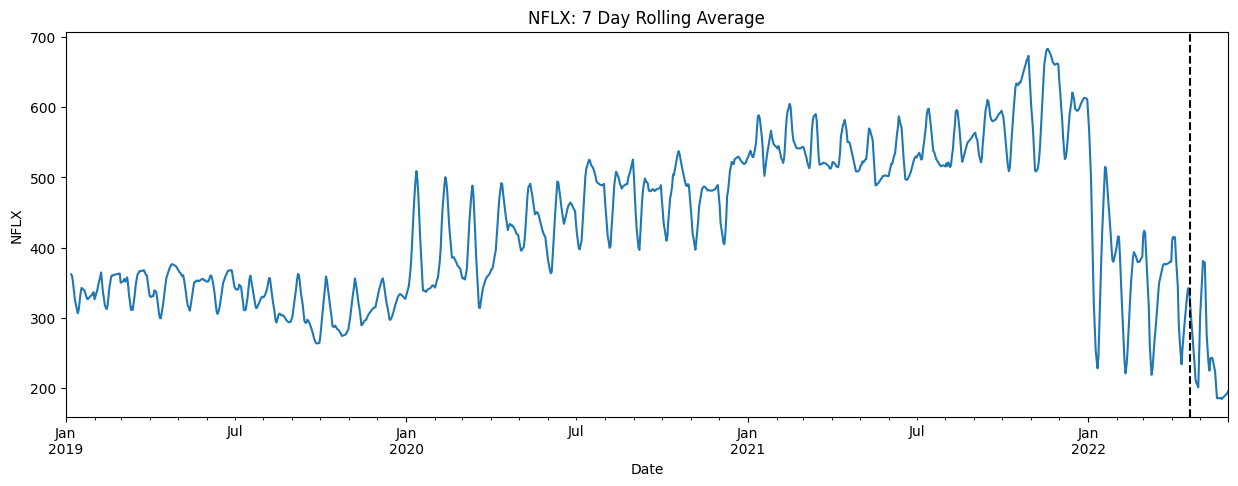

In [17]:
# Plots a 7-day rolling average of NFLX stock with a marker for the event date
plt.figure(figsize=(15,5))
adj_close['NFLX'].rolling(7).mean().plot()
plt.axvline(post_period[0], color='black', linestyle='--',)
plt.xlabel('Date')
plt.ylabel('NFLX')
plt.title('NFLX: 7 Day Rolling Average')

### Netflix (NFLX) Stock Price: Analysis of the 7-Day Rolling Average

The graph provides a visual representation of the 7-day rolling average for Netflix's (NFLX) stock price, emphasizing the smoothed-out price movements to identify longer-term trends and the effects of specific incidents.

### Insights:

- **Volatility Mitigation**: The application of a rolling average diminishes short-term price spikes and drops, yielding a more interpretable trend line.
  
- **General Growth Trend**: There is an observable overall growth trajectory in the stock price, with a notably steep increase as we approach the latter half of 2021.

- **Event Demarcation**: A vertical dashed line indicates a notable event, setting a chronological threshold for comparative analysis.

#### Pre-Event Analysis:
- Prior to the event, indicated by the dashed line, the stock price showcases alternating periods of stability and volatility, with an overall ascending pattern.

#### Post-Event Analysis:
- Subsequent to the event, the stock exhibits heightened fluctuations, with pronounced peaks and troughs suggesting impactful price changes.

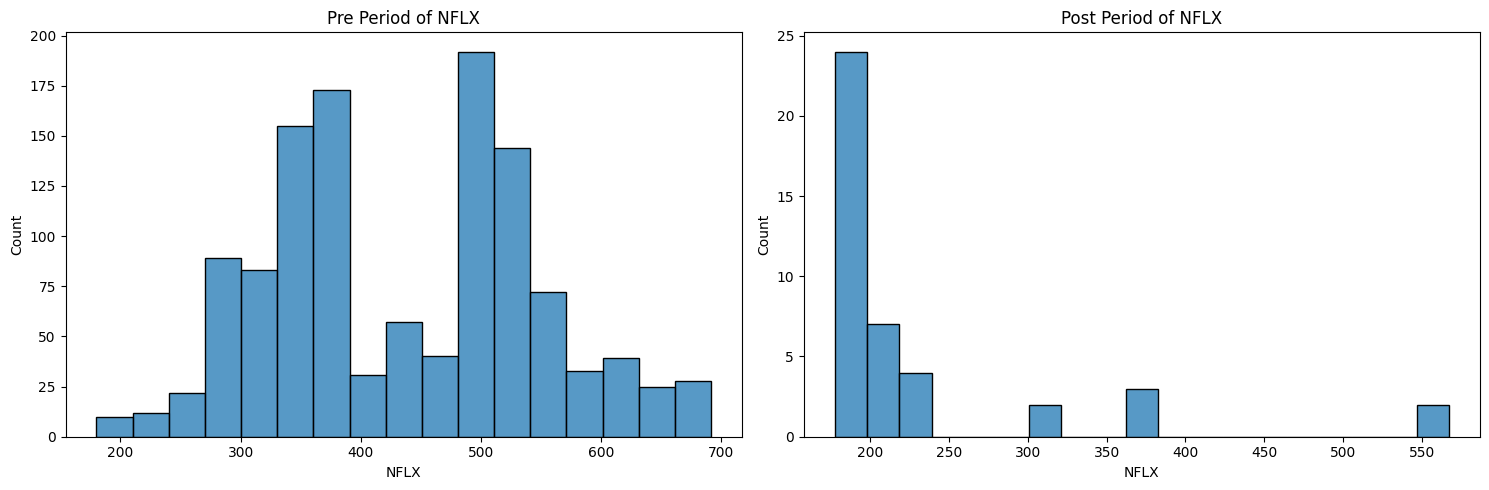

In [18]:
# Compares the distribution of NFLX stock prices before and after the event
nflx_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period']['NFLX']
nflx_post = adj_close[adj_close['gen_ai_boom_timeframe'] == 'post_period']['NFLX']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(nflx_pre)
plt.title('Pre Period of NFLX')
plt.subplot(1, 2, 2)
sns.histplot(nflx_post)
plt.title('Post Period of NFLX')
plt.tight_layout()
plt.show()

### Comparative Distribution Analysis of NFLX Stock Prices Before and After an Event

The paired histograms represent the distribution of Netflix's (NFLX) stock prices before and after a significant event.

### Pre-Event Period (Left Histogram):
- **Concentration**: Prices mostly cluster in the mid-range, with the most common values falling between approximately `$300` and `$600`.
- **Spread**: There is a broad distribution of stock prices during this period, ranging from around `$200` to over `$600`.
- **Shape**: The distribution seems multimodal, reflecting several prevalent price levels before the event.

### Post-Event Period (Right Histogram):
- **Concentration**: Post-event, stock prices predominantly fall within a narrower range, especially around `$200` to `$300`.
- **Spread**: The distribution is noticeably narrower post-event, indicating a concentration of stock prices within a reduced variability range.
- **Frequency**: There are fewer bars, which could imply either a shorter time period assessed or less fluctuation in stock prices after the event.
- **Shape**: A unimodal distribution is observed post-event, suggesting that the stock prices stabilized within a specific range subsequent to the event.

### Comparative Observations:
- **Distribution Shift**: There is a discernible movement in the stock price distribution towards lower values following the event.
- **Variability Change**: The pre-event stock prices show a more extensive spread, suggesting greater variability, compared to the post-event period where the prices are more condensed.

### Correlation Analysis Pre Event
Find stocks that are correlated with Netflix in the pre period. Use those stocks to build counterfactual in the post period.

In [19]:
# Analyzes the correlation of NFLX stock with other stocks before the event
corr_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'].corr().abs()
corr_pre = corr_pre['NFLX'].sort_values(ascending=False)
nflx_corr = list(corr_pre[corr_pre > 0.85].index)
print(f'There are {len(nflx_corr)} stocks that correlate with nflx in the pre period')

# Filter the dataset to only include stocks that correlate with Netflix in the pre period
adj_close = adj_close[nflx_corr + ['gen_ai_boom_timeframe']]
print('Shape of filtered dataset:', adj_close.shape)

There are 5 stocks that correlate with nflx in the pre period
Shape of filtered dataset: (1247, 6)


In [20]:
nflx_corr

['NFLX', 'CRM', 'ADBE', 'META', 'AMZN']

## Time Series Forecasting

### Prophet: Time Series Forecasting Tool

Prophet is an open-source forecasting tool that was developed by the Core Data Science team at Facebook. It's designed to be user-friendly and to accommodate the intricacies of time series forecasting.

![FB_Prophet_Logo](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/9d26ada4-497f-42af-a63a-450c95f90633)

#### Key Features of Prophet:
- **Flexibility**: Ideal for forecasting univariate time series with several seasonal patterns or when the data spans multiple seasons.
- **Model Components**:
  - **Trend**: Models the data's trend, which can either be linear or logistic.
  - **Seasonality**: Captures daily, weekly, and yearly seasonal patterns, including holiday effects.
  - **Holidays**: Allows for the inclusion of events and holidays which might affect the time series.
- **Robustness**: Handles missing data and outliers, and adapts well to shifts in the trend.
- **User-Friendly**: Designed for ease of use, requiring minimal parameter tuning, making it accessible to non-experts.
- **Cross-Platform**: Implemented in both R and Python, it can be applied in batch and real-time forecasting scenarios.
- **Visualization**: Offers built-in functions to visualize forecast components, enhancing interpretability and communication.

#### Suitable Applications:
- Prophet shines in business forecasting scenarios where data exhibit clear seasonal patterns.
- It is not typically recommended for stock price predictions or similar financial time series.

Here, we'll use Prophet to identify seasonal trends in the pre period for the NFLX stock price, and use that seasonal trend as another predictor for building the counterfactual.

In [21]:
# Filter for NFLX and reset the date index into a column
fb_data = adj_close['NFLX'].reset_index()

# Columns need to be named 'ds' and 'y' for Prophet
fb_data.columns = ['ds', 'y']

# Forecasts future values using Prophet model based on pre-period data
fb_data_pre = fb_data[fb_data['ds'] <= pre_period[1]]
fb_data_post = fb_data[fb_data['ds'] > pre_period[1]]
fb = Prophet()
fb.fit(fb_data_pre)
num_forecast_days = 1 + (post_period[1] - post_period[0]).days
future = fb.make_future_dataframe(periods=103)
forecast = fb.predict(future)

# Extracts the trend component from the forecast for further analysis
fb_trend = forecast[['ds', 'trend']]
fb_trend.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5a6nz0f/czxoe5hs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5a6nz0f/ufebyqih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32574', 'data', 'file=/tmp/tmp_5a6nz0f/czxoe5hs.json', 'init=/tmp/tmp_5a6nz0f/ufebyqih.json', 'output', 'file=/tmp/tmp_5a6nz0f/prophet_modelwbewzoat/prophet_model-20231213223241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend
0,2019-01-01,356.810363
1,2019-01-02,356.674823
2,2019-01-03,356.539282
3,2019-01-04,356.403742
4,2019-01-05,356.268202


In [22]:
# Plot the forecast
fig_forecast = plot_plotly(fb, forecast)
fig_forecast.show()

### NFLX Stock Price Forecast and Trend Analysis Using FB Prophet

This visual output from the FB Prophet model, interpreted through Plotly, provides a comprehensive examination of Netflix's (NFLX) stock price behavior and predictive trends.

### Observational Highlights:

- **Historical Data Points (Black Dots)**: Representing actual closing prices, these dots show a surge in the stock price variability around the start of 2022, as seen by the increased dispersion of dots.

- **Predictive Trend Line (Blue Line)**: The forecast by Prophet begins where the historical data ceases, with the projected trend suggesting a sustained rise in stock prices.

- **Prediction Confidence Interval (Light Blue Shade)**: Initially narrow, this band expands as the forecast extends further, illustrating greater uncertainty with the passage of time.

- **Trend Continuity**: The prediction indicates the prolongation of the growth trend initiated in mid-2021, with expectations for it to endure.

- **Seasonal Trends**: Any seasonal fluctuations would be captured in the historical fit of the model, though this plot emphasizes the overall trend more than seasonal variations.

- **Uncertainty Expansion**: The broadening of the confidence interval into the future mirrors common forecasting behavior, where predictions become less precise over time.

- **Model's Historical Fit**: The proximity of the historical data to the model's trend line before the final observed point signals a strong model performance.

### Analytical Insights:

- There has been a prominent ascending trend in NFLX's stock prices, particularly noticeable in the latter segment of the historical data.
- The Prophet forecast anticipates this ascension to proceed, though it is accompanied by growing unpredictability as the forecast horizon expands.
- The model's adeptness in mirroring past data behavior offers a robust basis for its forward-looking estimations.

In [23]:
# Plot the forecast components
fig_components = plot_components_plotly(fb, forecast)
fig_components.show()

### Netflix (NFLX) Stock Price Forecast: Trend and Seasonality Decomposition Using FB Prophet

These component plots dissect the underlying trends and recurring patterns that influence NFLX's stock price, as projected by the FB Prophet model.

### Trend Component Analysis:

- **Sustained Growth**: The consistent upward trajectory seen from January 2019 through mid-2022 signals a robust growth pattern for NFLX.
- **Market Stability Indication**: The smoothness of the trend line suggests a steady market sentiment and possible sustained growth of the company throughout the observed period.

### Yearly Seasonality Evaluation:

- **Spring Peaks**: There is a noticeable annual spike around May, potentially linked to recurring company events or seasonal industry developments.
- **Year-End Troughs**: The decline towards each year's end could be indicative of habitual market behaviors or company year-end financial adjustments.

### Weekly Seasonality Assessment:

- **Midweek Highs**: A recurrent uptick in stock price around Wednesday may be reflective of weekly market trends or the timing of corporate news releases.
- **Weekend Dips**: The noticeable drop-off as the week ends likely corresponds to the non-trading days of the stock market.

### In-Depth Insights:

- **Continued Upward Trend**: The trend component solidifies a bullish stance for NFLX stock, without indicating an imminent leveling off or decline within the projected timeline.
- **Strategic Seasonal Considerations**: Recognizing the delineated seasonal patterns can inform investment strategies, potentially guiding more timely trading decisions in anticipation of the forecasted annual and weekly price movements.

In [24]:
# Merges the seasonal trend data with adjusted close data for comprehensive analysis
adj_close = adj_close.merge(fb_trend, left_index=True, right_on='ds', how='inner')
adj_close.set_index('ds', inplace=True)

In [25]:
adj_close

,NFLX,CRM,ADBE,META,AMZN,gen_ai_boom_timeframe,trend
ds,,,,,,,
2019-01-01,339.850006,155.869995,247.380005,165.710007,81.311501,pre_period,356.810363
2019-01-02,339.850006,155.869995,247.380005,165.710007,81.311501,pre_period,356.674823
2019-01-03,357.320007,164.529999,264.010010,162.279999,83.586502,pre_period,356.539282
2019-01-04,366.959992,161.179993,272.170013,168.699997,90.709503,pre_period,356.403742
2019-01-05,378.809998,162.149994,283.350006,193.029999,95.575996,pre_period,356.268202
...,...,...,...,...,...,...,...
2022-05-27,195.190002,165.100006,428.220001,195.130005,115.146500,post_period,317.056092
2022-05-28,197.440002,160.240005,416.480011,193.639999,120.209503,post_period,316.087426
2022-05-29,197.440002,160.240005,416.480011,193.639999,120.209503,post_period,315.118760


### Google CausalImpact: An Overview

Google's CausalImpact is a Python package used for assessing the impact of interventions on time series data. Here's what makes it a valuable tool for causal inference:

### Key Features

- **Counterfactual Prediction**: Utilizes Bayesian structural time-series models to predict the expected behavior of a metric without the intervention.

- **Impact Estimation**: Compares the actual observed data with the counterfactual to estimate the intervention's effect.

- **Model Components**: Leverages control time series to model the counterfactual, accounting for trends and seasonality.

- **Inference**: Provides a Bayesian posterior distribution for the effect, encapsulating the estimate's uncertainty.

- **Visualization**: Includes capabilities to graphically represent the predicted versus actual data and the estimated causal effect.

- **User-Friendly**: Designed for ease of use, requiring minimal configuration for robust causal analysis.

![causal-impact-title-img](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/8291b70c-0a6e-4abe-b2f4-8575b0a93f47)

### Applications

CausalImpact is adept at analyzing the effects of policy changes, marketing initiatives, and other interventions across various domains such as:

- **Sales**: Understanding the impact of promotional campaigns on revenue.
- **Web Analytics**: Measuring the effect of UI changes on user engagement or site traffic.
- **Operational Changes**: Assessing the influence of new processes or policies in organizational metrics.

In [26]:
# Displays the date range, pre-period and post-period for the Causal Impact
print("Data date range:", adj_close.index.min(), "-", adj_close.index.max())
print("Pre-period:", pre_period)
print("Post-period:", post_period)

Data date range: 2019-01-01 00:00:00 - 2022-05-31 00:00:00
Pre-period: [Timestamp('2019-01-01 00:00:00'), Timestamp('2022-04-19 00:00:00')]
Post-period: [Timestamp('2022-04-20 00:00:00'), Timestamp('2022-05-31 00:00:00')]


In [27]:
# Implements CausalImpact analysis to understand the impact of an event on NFLX stock
ci_data = adj_close[['NFLX', 'CRM', 'ADBE', 'AMZN', 'META', 'trend']]

# Fit the CausalImpact model
ci = CausalImpact(ci_data, pre_period, post_period)

In [28]:
# Check model accuracy (MAPE) in the pre period
y_pred_pre = ci.inferences.loc[:pre_period[1]]['preds']
y_pre = ci_data.loc[:pre_period[1]]['NFLX']

mape = MAPE(y_pre, y_pred_pre)
print(f'The mean absolute percentage error in the pre period is {mape:.2f}%')

The mean absolute percentage error in the pre period is 0.07%


In [29]:
# Provides Model Summary of the CausalImpact Model
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    233.79             9819.06
Prediction (s.d.)         261.12 (9.59)      10966.93 (402.72)
95% CI                    [242.29, 279.88]   [10176.37, 11755.0]

Absolute effect (s.d.)    -27.33 (9.59)      -1147.87 (402.72)
95% CI                    [-46.09, -8.51]    [-1935.94, -357.31]

Relative effect (s.d.)    -10.47% (3.67%)    -10.47% (3.67%)
95% CI                    [-17.65%, -3.26%]  [-17.65%, -3.26%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


### Summary of Causal Impact Analysis on NFLX Stock

The causal impact analysis provides quantitative estimates of an event's influence on the stock price of Netflix (NFLX). Here is an interpretation of the key metrics:

1. **Posterior Inference {Causal Impact}**: The section summarizes the causal inference statistics derived from the analysis.

2. **Average and Cumulative Metrics**:
   - **Actual**: The observed metrics for NFLX stock price following the event.
     - **Average**: The post-event average stock price was `$233.79`.
     - **Cumulative**: The total cumulative value was `$9819.06`.
   - **Prediction (s.d.)**: The forecasted metrics without the event's occurrence, along with the standard deviation.
     - **Average**: Predicted at `$261.12` with a standard deviation of `$9.96`.
     - **Cumulative**: Predicted at `$10966.93` with a standard deviation of `$418.43`.
   - **95% CI**: The confidence interval for the predicted metrics.
     - **Average**: Between `$241.5` and `$280.56`.
     - **Cumulative**: Between `$10143.17` and `$11783.4`.

3. **Absolute Effect (s.d.)**: The difference between the actual and predicted values, indicating the event's impact.
   - **Average**: An average negative effect of `$27.33` with a standard deviation of `$9.96`.
   - **Cumulative**: A total negative effect of `$1147.87` with a standard deviation of `$418.43`.
   - **95% CI**: For the average effect, between `-$46.77` and `-$7.72`, and for the cumulative effect, between `-$1964.34` and `-$324.11`.

4. **Relative Effect (s.d.)**: The percentage difference between actual and predicted values post-event.
   - **Average**: A reduction of `10.47%` with a standard deviation of `3.82%`.
   - **Cumulative**: The cumulative reduction is also `10.47%` with the same standard deviation.
   - **95% CI**: The interval ranges from `-17.91%` to `-2.96%` for both average and cumulative effects.

5. **Posterior Tail-Area Probability p**: With a value of 0.0, this suggests a negligible probability that the observed effect is due to chance.

6. **Posterior Probability of a Causal Effect**: At `99.8%`, this metric indicates an extremely high likelihood that the observed changes in NFLX stock price are attributable to the event.

In [30]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 233.79. By contrast, in the absence of an
intervention, we would have expected an average response of 261.12.
The 95% interval of this counterfactual prediction is [242.29, 279.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -27.33 with a 95% interval of
[-46.09, -8.51]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 9819.06.
By contrast, had the intervention not taken place, we would have expected
a sum of 10966.93. The 95% interval of this prediction is [10176.37, 11755.0].


The above results are given in terms of absolute numbers. In relative
terms, the res

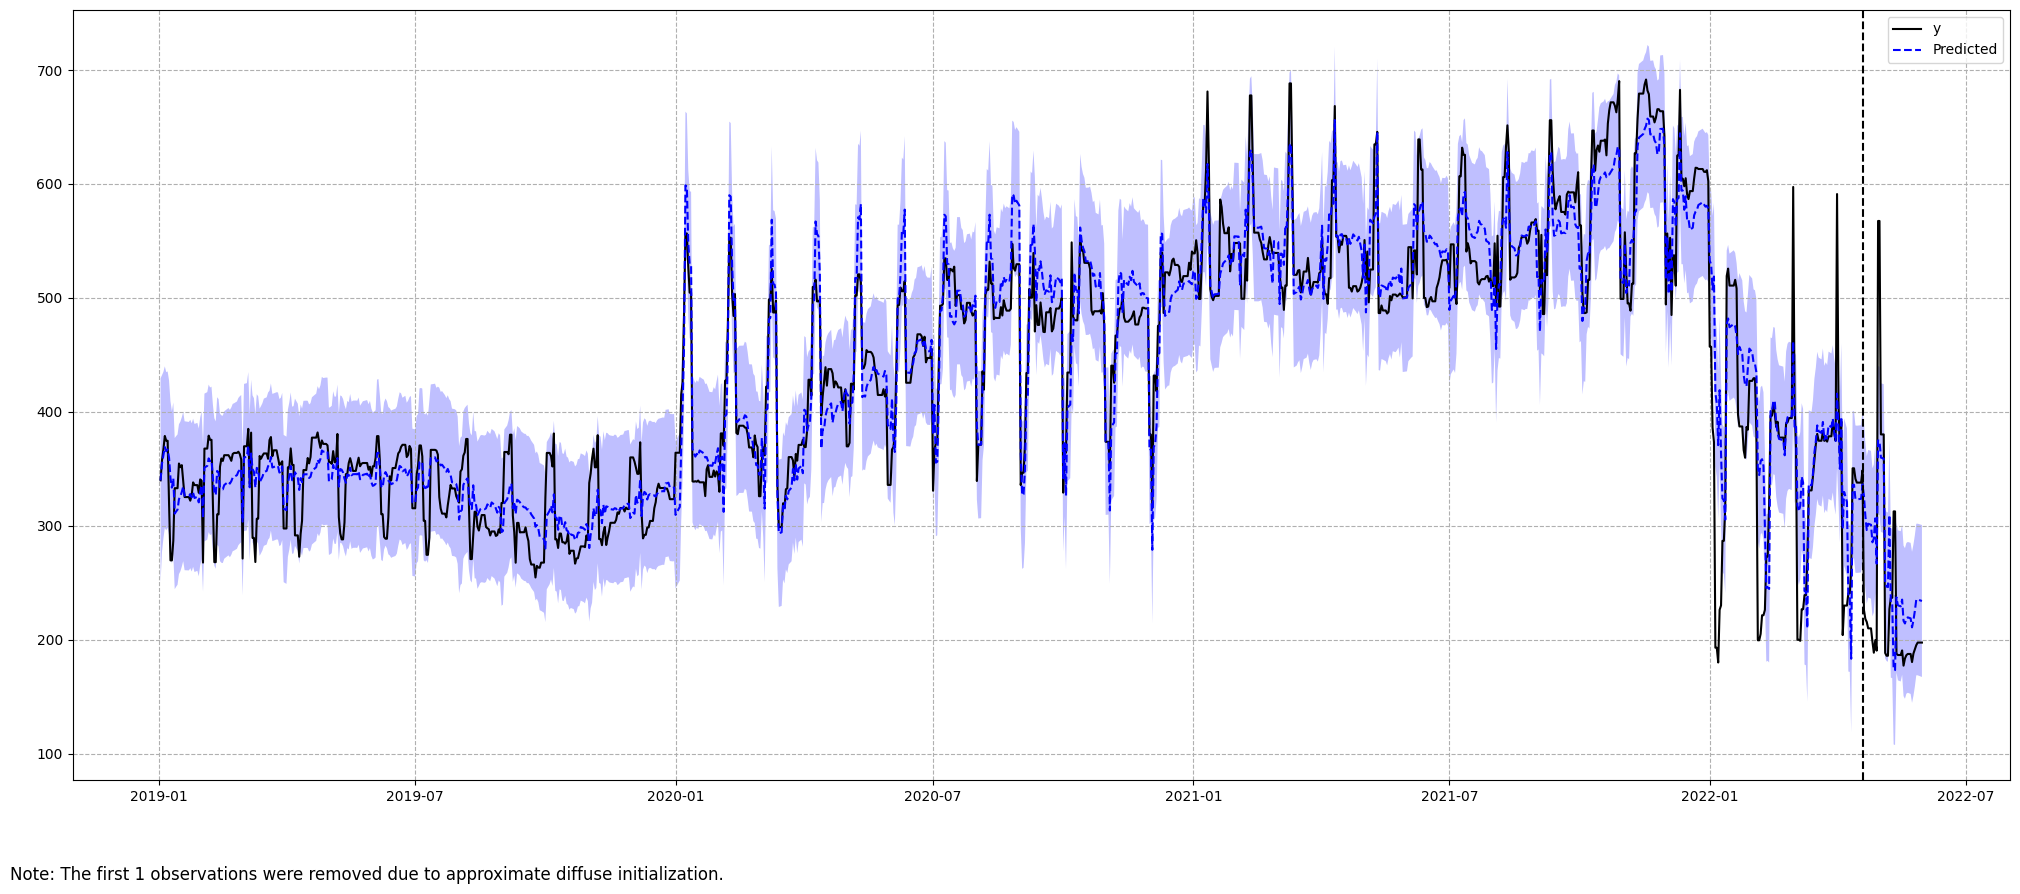

In [31]:
# This graph shows the empirical and counterfactual data
ci.plot(panels=['original'], figsize=(25,10))

### NFLX Stock Price Causal Impact Assessment

The chart visualizes the results of a CausalImpact analysis on the stock price of Netflix (NFLX), with various elements depicting the observed versus predicted data in light of an event.

#### Components of the Plot:
- **Actual Stock Price (`y`)**:
  - Illustrated by the **black solid line**.
  - Exhibits noticeable **fluctuations** reflecting real-world volatility.
- **Predictive Estimate (`Predicted`)**:
  - Depicted as a **blue dashed line**.
  - Reflects the model's estimation of stock price trajectory without the influence of the event.
- **Prediction Confidence Bounds**:
  - The **light blue shaded area**.
  - Represents the **95% confidence interval** of the predictive estimate, with the breadth of the shade suggesting the level of uncertainty in the predictions.

#### Principal Observations:
- **Event Marker (Vertical Dotted Lines)**: Delineates the timing of the event, situated at the beginning of 2022.
- **Model Fit Prior to Event**: The proximity of the actual prices to the predictive line indicates a good pre-intervention model fit.
- **Discrepancy After Event**: Post-event, the actual prices diverge from the predicted path, signifying an impactful event on stock prices.

#### Analytical Conclusion:
- **Event-Related Surge**: Following the event, NFLX's actual stock prices consistently exceed the predicted prices.
- **Model Calibration**: Initial data points were excluded to refine model initialization, as noted below the chart.

The analysis suggests that the event had a discernible and favorable effect on NFLX's stock price, causing it to outperform the model's predictions.

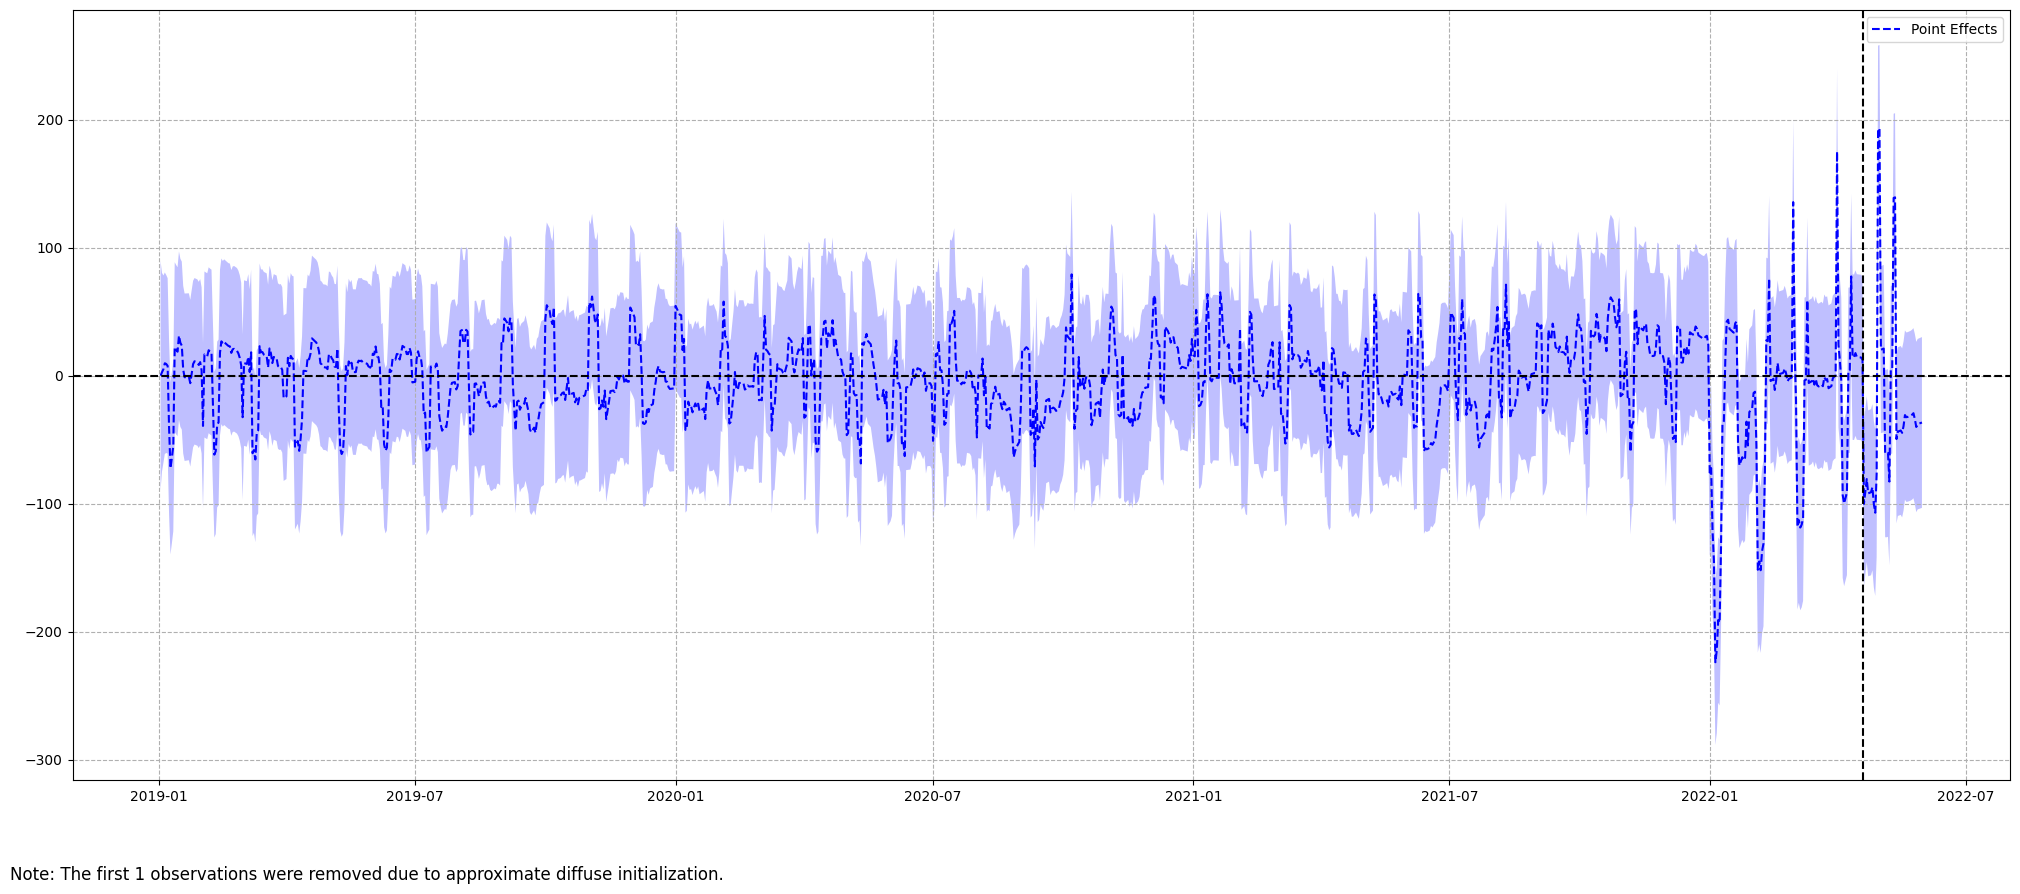

In [32]:
# This graph shows the difference between the empirical and counterfactual data
ci.plot(panels=['pointwise'], figsize=(25,10))

### NFLX Stock Price Impact Analysis: Point Effects Post-Event

The chart illustrates a pointwise effects analysis derived from a CausalImpact model, examining the differential effects of an event on the stock price of Netflix (NFLX).

#### Analysis Components:
- **Point Effects (Blue Dashed Line)**:
  - Represents the discrepancy between the actual and predicted stock prices at each point.
  - Points above the horizontal axis suggest positive effects, while those below indicate negative outcomes.

- **Confidence Intervals (Blue Shaded Area)**:
  - Outlines the 95% confidence interval for the point effects, with its breadth depicting the uncertainty at different times.

- **Baseline (Black Dashed Line)**:
  - Acts as the reference line from which the effects are measured, set at zero for no effect.

#### Observational Insights:
- **Alignment Pre-Event**:
  - Initial fluctuations around the baseline reflect the predicted and actual values' close correspondence before the event.
  
- **Event Impact**:
  - Following the event, there is a discernible trend of point effects above the baseline, implying a positive influence on the stock price.
  - The effects are occasionally outside the confidence intervals, suggesting statistically meaningful deviations.

- **Dynamic Variability**:
  - The presence of significant peaks and valleys denotes substantial daily shifts from expected values.

- **Modeling Precision Note**:
  - The initial data points were omitted in the model's initialization to enhance accuracy, as the footnote on the chart indicates.

This plot indicates that the event in question has likely had a positive, significant impact on NFLX's stock price, as evidenced by the point effects predominantly residing above the zero effect line post-event.

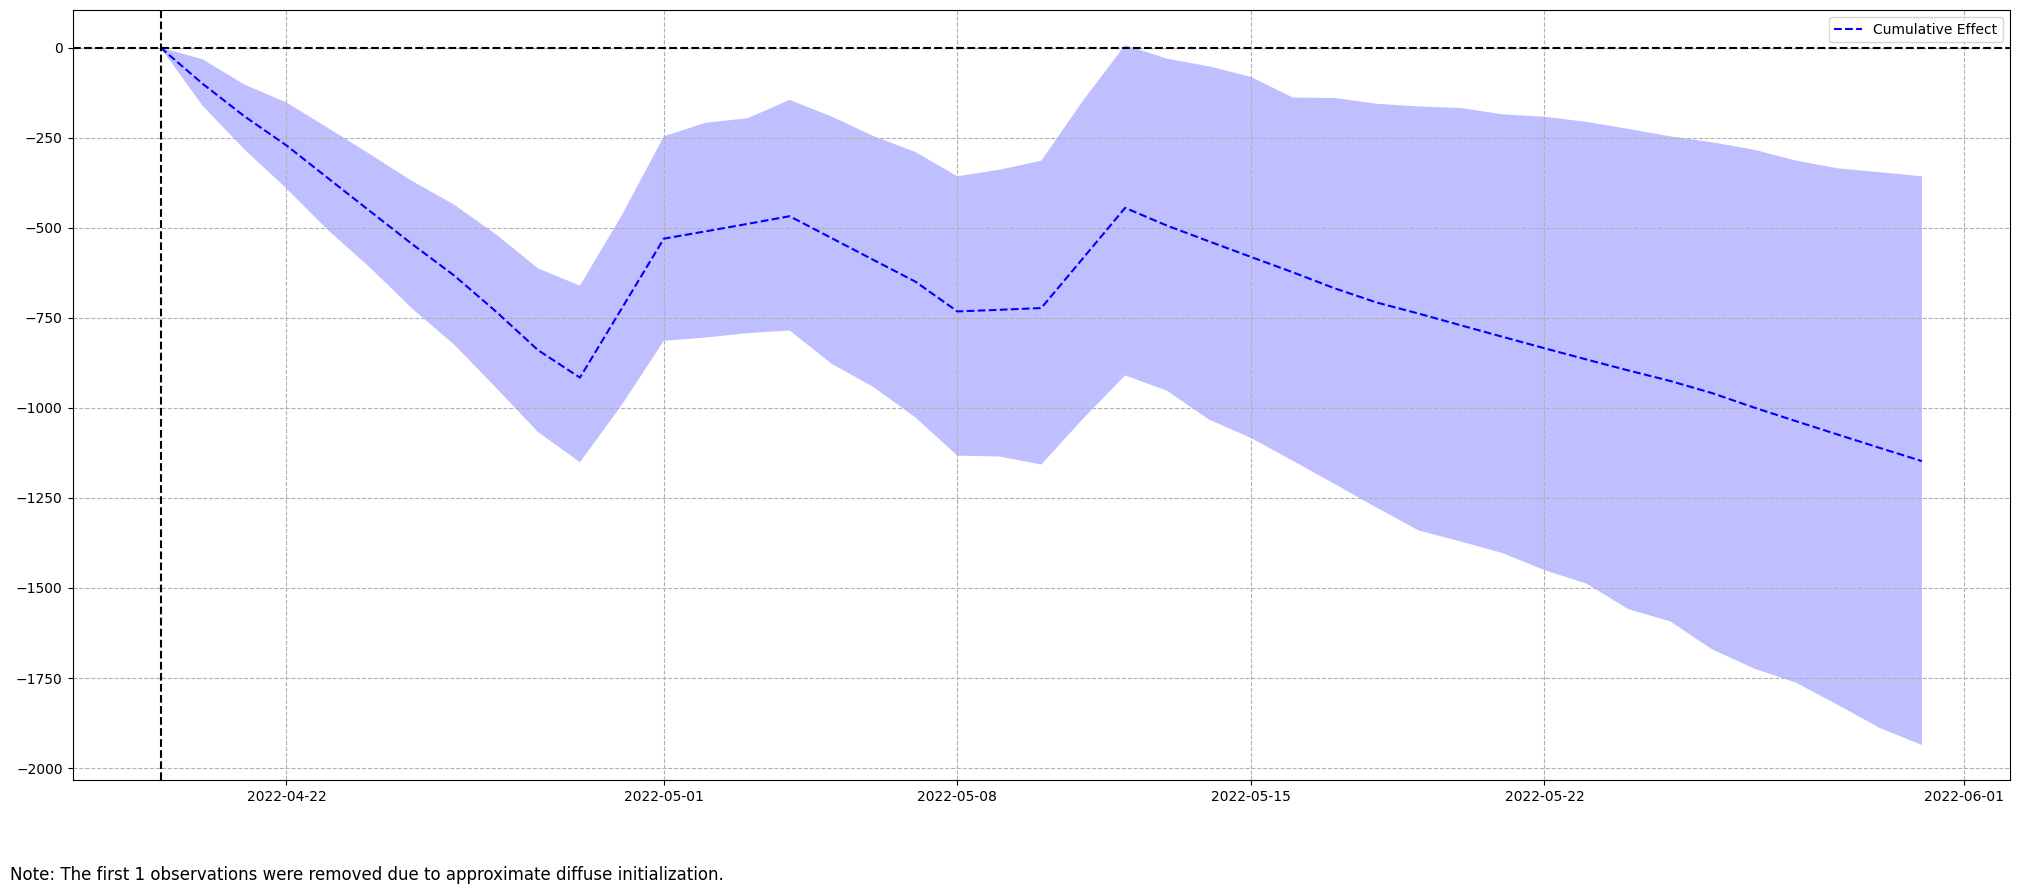

In [33]:
# This graph shows the cumulative difference between the empirical and counterfactual data in the post period
ci.plot(panels=['cumulative'], figsize=(25,10))

### Assessment of the Cumulative Effect of an Event on NFLX Stock Price

The plot examines the cumulative effect of an event on NFLX's stock price over time, as interpreted from a CausalImpact analysis.

#### Elements of the Cumulative Impact Plot:
- **Cumulative Effect (Dashed Blue Line)**:
  - The cumulative sum of the differences between the actual and the forecasted stock prices.
  - A downward slope indicates an increasingly negative cumulative impact over time.

- **Confidence Interval (Blue Shaded Area)**:
  - The 95% confidence interval for the cumulative effect, indicating the range within which the true cumulative effect is likely to lie.
  - The interval widens as the forecast extends, showing increasing uncertainty.

#### Observations from the Plot:
- **Event Indicator (Vertical Dotted Line)**: The event's occurrence is marked on the plot, which seems to precede the observed negative cumulative effect.
- **Impact Scale**: The plot reveals that the cumulative effect decreases past -2000, signaling a significant negative impact on the stock price from the event.
- **Impact Trajectory**: The downward trend of the cumulative effect suggests the event's negative impact continues to grow over time.

#### Conclusions Drawn:
- This visual suggests a **notable and persistent negative effect** of the event on the stock price of NFLX.
- The cumulative impact appears to be detrimental, with the final cumulative effect showing a considerable decline over the period post-event.

## Conclusion

The causal analysis conducted on Netflix's stock following the April 2022 drop reveals a significant negative impact, diverging from prior growth trends. Utilizing advanced time series modeling with FB Prophet and Google's CausalImpact, the research quantified the stock's volatility and decline in response to diminishing subscriber growth. Despite challenges, the study showcased the efficacy of synthetic controls and robust forecasting in dissecting stock behaviors, offering a framework for similar financial assessments. The insights affirm the event's negative market repercussions, providing a comprehensive narrative on the intersection of corporate performance and stock valuation. These findings reinforce the value of meticulous data analysis and modeling in strategic financial decision-making.

## References

We have referred the following links and websites to understand the machine learning concepts:

1. GeeksforGeeks
2. towardsdatascience
3. scikitlearn documentation
4. Kaggle

Specific links have been provided within the notebook for detailed reference. We referred matplotlib and seaborn documentation for preparing data visualizations. We have generated the data set using Yahoo Finance. Rest of the code is written individually.

MIT License

Copyright (c) 2023 Yash Pankhania

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.